<a href="https://colab.research.google.com/github/matthewpecsok/4482_fall_2022/blob/main/tutorials/4482_KNN_scaled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will be covering a new modeling technique called K-Nearest Neighbors. 

A quick reminder about the model requirements that Dr. Sheng talks about in her videos are that the data must be standardized to have each column be on the same scale. Having columns on different scales will cause issues with distance calculations.

We will demonstrate this before diving deeper.


https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

## Setup

In [9]:
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix,\
recall_score, precision_score, f1_score, accuracy_score, make_scorer,\
precision_recall_fscore_support, mean_absolute_error, mean_squared_error

from sklearn.model_selection import train_test_split, cross_validate

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier




## Data

In [10]:
titanic_cleaned = pd.read_csv('https://raw.githubusercontent.com/matthewpecsok/4482_fall_2022/main/data/titanic_cleaned.csv').drop('Cabin',axis=1)

In [11]:
titanic_cleaned.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [12]:
titanic_cleaned.Pclass = titanic_cleaned.Pclass.astype('object')

In [13]:
X = pd.get_dummies(titanic_cleaned.drop('Survived', axis=1))
y = titanic_cleaned.Survived
print(X.shape, y.shape)

(714, 13) (714,)


In [14]:
X.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_missing
0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1,0
1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0,0
2,26.0,0,0,7.9250,0,0,1,1,0,0,0,1,0
3,35.0,1,0,53.1000,1,0,0,1,0,0,0,1,0
4,35.0,0,0,8.0500,0,0,1,0,1,0,0,1,0


# Model assumption testing preparation

##demonstrate a random number generator

In [15]:
import random
random.randint(100000,9999999) # generate a really big number randomly

6171175

## apply random numbers to a new column

In [16]:
X_random_col = X.copy()
X_random_col['a_random_big'] = random.sample(range(9999999, 99999999), X_random_col.shape[0]) # now generate a bunch of random numbers one new number for each row
X_random_col[['Age','a_random_big']].head()

,Age,a_random_big
0,22.0,75839886
1,38.0,62314441
2,26.0,63072695
3,35.0,92032295
4,35.0,77004297


# Standard Scaler

StandardScaler allows us to convert existing unscaled data into scaled data. A quick demonstration showing this in action on our dataframe is below. Notice how our data is on different scales prior to transforming the data with StandardScaler

Before

In [17]:
X

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_missing
0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1,0
1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0,0
2,26.0,0,0,7.9250,0,0,1,1,0,0,0,1,0
3,35.0,1,0,53.1000,1,0,0,1,0,0,0,1,0
4,35.0,0,0,8.0500,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,39.0,0,5,29.1250,0,0,1,1,0,0,1,0,0
710,27.0,0,0,13.0000,0,1,0,0,1,0,0,1,0
711,19.0,0,0,30.0000,1,0,0,1,0,0,0,1,0
712,26.0,0,0,30.0000,1,0,0,0,1,1,0,0,0


After

notice that we have lost our column names, but the data is now much consistent. technically we don't need to scale our One-Hot encoded data as the scale was very close already, but we let StandardScaler transform it for ease of reading here. 

In [18]:
pd.DataFrame(StandardScaler().fit_transform(X))

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-0.530377,0.524570,-0.505895,-0.518978,-0.593526,-0.565489,1.005618,-0.759051,0.759051,-0.471808,-0.202031,0.537409,-0.053
1,0.571831,0.524570,-0.505895,0.691897,1.684847,-0.565489,-0.994413,1.317434,-1.317434,2.119506,-0.202031,-1.860779,-0.053
2,-0.254825,-0.551703,-0.505895,-0.506214,-0.593526,-0.565489,1.005618,1.317434,-1.317434,-0.471808,-0.202031,0.537409,-0.053
3,0.365167,0.524570,-0.505895,0.348049,1.684847,-0.565489,-0.994413,1.317434,-1.317434,-0.471808,-0.202031,0.537409,-0.053
4,0.365167,-0.551703,-0.505895,-0.503850,-0.593526,-0.565489,1.005618,-0.759051,0.759051,-0.471808,-0.202031,0.537409,-0.053
...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,0.640719,-0.551703,5.357890,-0.105320,-0.593526,-0.565489,1.005618,1.317434,-1.317434,-0.471808,4.949747,-1.860779,-0.053
710,-0.185937,-0.551703,-0.505895,-0.410245,-0.593526,1.768380,-0.994413,-0.759051,0.759051,-0.471808,-0.202031,0.537409,-0.053
711,-0.737041,-0.551703,-0.505895,-0.088774,1.684847,-0.565489,-0.994413,1.317434,-1.317434,-0.471808,-0.202031,0.537409,-0.053
712,-0.254825,-0.551703,-0.505895,-0.088774,1.684847,-0.565489,-0.994413,-0.759051,0.759051,2.119506,-0.202031,-1.860779,-0.053


## now do the same to a lot of columns 

In [19]:
X_random_columns_scaled = X.copy()
X_random_columns_scaled['a_random_big'] = random.sample(range(9999999, 99999999), X_random_col.shape[0])
X_random_columns_scaled['b_random_big'] = random.sample(range(9999999, 99999999), X_random_col.shape[0])
X_random_columns_scaled['c_random_big'] = random.sample(range(9999999, 99999999), X_random_col.shape[0])
X_random_columns_scaled['d_random_big'] = random.sample(range(9999999, 99999999), X_random_col.shape[0])
X_random_columns_scaled['e_random_big'] = random.sample(range(9999999, 99999999), X_random_col.shape[0])

 # now generate a bunch of random numbers one new number for each row
print('prescaled',"\n")
display(X_random_columns_scaled[['Age','a_random_big','b_random_big','c_random_big','d_random_big','e_random_big']].head())

#now scale

# keep the column names since we will lose them
column_names = X_random_columns_scaled.columns

X_random_columns_scaled = StandardScaler().fit_transform(X_random_columns_scaled)
X_random_columns_scaled = pd.DataFrame(X_random_columns_scaled,columns = column_names )
print("\n",'scaled')
X_random_columns_scaled.head()
 

prescaled 



,Age,a_random_big,b_random_big,c_random_big,d_random_big,e_random_big
0,22.0,98033148,38278159,30902213,19439247,32905413
1,38.0,64584831,54905838,75072341,20284806,63133137
2,26.0,93752051,99635416,16283297,14075133,92645709
3,35.0,33048295,15717117,87854701,36571930,75671013
4,35.0,81598293,50987622,50655856,53864662,89541692



 scaled


,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_missing,a_random_big,b_random_big,c_random_big,d_random_big,e_random_big
0,-0.530377,0.524570,-0.505895,-0.518978,-0.593526,-0.565489,1.005618,-0.759051,0.759051,-0.471808,-0.202031,0.537409,-0.053,1.721835,-0.668917,-0.898826,-1.301743,-0.851482
1,0.571831,0.524570,-0.505895,0.691897,1.684847,-0.565489,-0.994413,1.317434,-1.317434,2.119506,-0.202031,-1.860779,-0.053,0.410461,-0.028483,0.789144,-1.268839,0.304592
2,-0.254825,-0.551703,-0.505895,-0.506214,-0.593526,-0.565489,1.005618,1.317434,-1.317434,-0.471808,-0.202031,0.537409,-0.053,1.553991,1.694326,-1.457491,-1.510484,1.433315
3,0.365167,0.524570,-0.505895,0.348049,1.684847,-0.565489,-0.994413,1.317434,-1.317434,-0.471808,-0.202031,0.537409,-0.053,-0.825960,-1.537880,1.277624,-0.635036,0.784109
4,0.365167,-0.551703,-0.505895,-0.503850,-0.593526,-0.565489,1.005618,-0.759051,0.759051,-0.471808,-0.202031,0.537409,-0.053,1.077491,-0.179398,-0.143937,0.037900,1.314601


# Dummy Classifier

https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

dummy classifiers are useful because they allow us to see how a Naive classification strategy would perform. This establishes a baseline that we can try and beat with our model. It's often suprisingly hard to do better than some of these strategies. 

In [20]:
print("uniform f1 cv score:",round(cross_val_score(DummyClassifier(strategy="uniform"),X_random_col, y,scoring='f1').mean(),2))
print("stratified f1 cv score:",round(cross_val_score(DummyClassifier(strategy="stratified"),X_random_col, y,scoring='f1').mean(),2))

uniform f1 cv score: 0.46
stratified f1 cv score: 0.34


In [21]:
parameters = {'n_neighbors': [i for i in range(50)],
              'p': [i for i in range(2)]  
              }

# KNN with unscaled data with random large columns

Notice the POOR performance here. Since we have data that is unscaled our model performs no better than the stratified dummy classifier. This is a poor performing model because our data is not prepared properly. 

In [49]:
clf = GridSearchCV(KNeighborsClassifier(), parameters,scoring='f1', return_train_score=True).fit(X_random_col, y)
result_df = pd.DataFrame(clf.cv_results_)
result_df[result_df['rank_test_score']==1]['mean_test_score']

4    0.470107
5    0.470107
Name: mean_test_score, dtype: float64

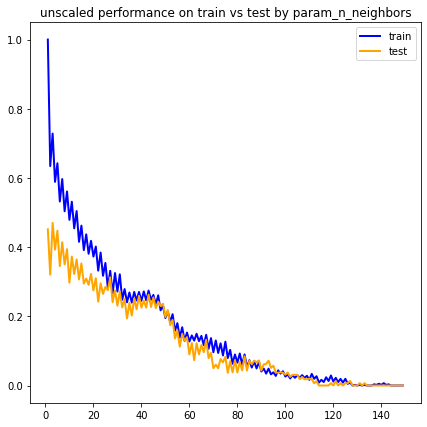

In [51]:
plt.figure(figsize=(7,7))
plt.plot('param_n_neighbors', 'mean_train_score', data=result_df, marker='', color='blue', linewidth=2, label="train")
plt.plot('param_n_neighbors', 'mean_test_score', data=result_df, marker='', color='orange', linewidth=2, label="test")


plt.legend()
plt.title("unscaled performance on train vs test by param_n_neighbors")
plt.show()

# KNN with scaled data random columns

Notice the MUCH BETTER performance here. Now that we have scaled our data our model performance is substantially better than our unscaled and dummy classifiers. 

In [23]:
clf = GridSearchCV(KNeighborsClassifier(), parameters,scoring='f1', return_train_score=True).fit(X_random_columns_scaled, y)
result_df = pd.DataFrame(clf.cv_results_)
result_df[result_df['rank_test_score']==1]['mean_test_score']

17    0.705539
Name: mean_test_score, dtype: float64

# KNN with scaled original data

Notice the performance here. Eliminating the random columns increases the performance slightly. 

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
X_scaled[:2]

# notice that StandardScaler has converted the data to a numpy array. we have lost the column names. 

array([[-0.53037664,  0.52457013, -0.50589515, -0.51897787, -0.59352568,
        -0.56548934,  1.00561802, -0.75905134,  0.75905134, -0.47180795,
        -0.20203051,  0.53740921, -0.05299989],
       [ 0.57183099,  0.52457013, -0.50589515,  0.69189675,  1.68484708,
        -0.56548934, -0.99441336,  1.31743394, -1.31743394,  2.11950647,
        -0.20203051, -1.86077941, -0.05299989]])

In [25]:
clf = GridSearchCV(KNeighborsClassifier(), parameters,scoring='f1', return_train_score=True).fit(X_scaled, y)
result_df = pd.DataFrame(clf.cv_results_)
result_df[result_df['rank_test_score']==1]['mean_test_score']

7    0.725885
Name: mean_test_score, dtype: float64

## KNN hyperparameter exploration

In [36]:
parameters = {'n_neighbors': [i for i in range(1,150)],
              'p': [1,2]  
              }

clf = GridSearchCV(KNeighborsClassifier(), parameters,scoring='f1', return_train_score=True).fit(X_scaled, y)
result_df = pd.DataFrame(clf.cv_results_)
#result_df[result_df['rank_test_score']==1]['mean_test_score']

Evaluating the model default of 5 nearest neighbors. Would that strategy have achieve good results for us in this modeling task?

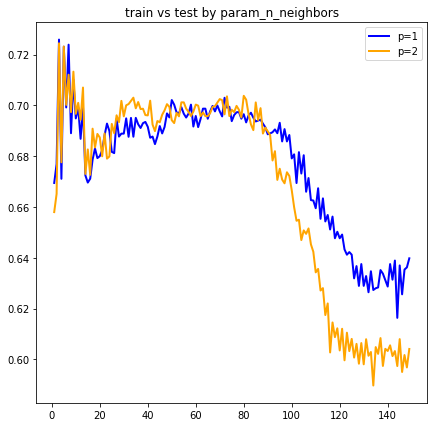

In [48]:
plt.figure(figsize=(7,7))
plt.plot('param_n_neighbors', 'mean_test_score', data=result_df[result_df['param_p']==1], marker='', color='blue', linewidth=2, label="p=1")
plt.plot('param_n_neighbors', 'mean_test_score', data=result_df[result_df['param_p']==2], marker='', color='orange', linewidth=2, label="p=2")


plt.legend()
plt.title("train vs test by param_n_neighbors")
plt.show()

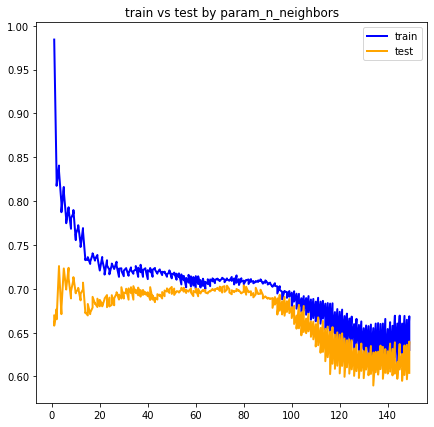

In [46]:
plt.figure(figsize=(7,7))
plt.plot('param_n_neighbors', 'mean_train_score', data=result_df, marker='', color='blue', linewidth=2, label="train")
plt.plot('param_n_neighbors', 'mean_test_score', data=result_df, marker='', color='orange', linewidth=2, label="test")


plt.legend()
plt.title("train vs test by param_n_neighbors")
plt.show()

In [42]:
result_df[['param_n_neighbors','param_p','mean_test_score']].sort_values(by='mean_test_score',ascending=False).head(10)

,param_n_neighbors,param_p,mean_test_score
4,3,1,0.725885
5,3,2,0.724431
12,7,1,0.723879
9,5,2,0.723152
8,5,1,0.723092
17,9,2,0.713256
13,7,2,0.712056
16,9,1,0.710061
25,13,2,0.707001
159,80,2,0.703745


In [52]:
knn = KNeighborsClassifier()


In [53]:
knn.fit(X,y)

KNeighborsClassifier()

In [56]:
knn_graph = knn.kneighbors_graph()

In [60]:
knn_graph_arr = knn_graph.toarray()

In [61]:
knn_graph_arr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [62]:
X

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_missing
0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1,0
1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0,0
2,26.0,0,0,7.9250,0,0,1,1,0,0,0,1,0
3,35.0,1,0,53.1000,1,0,0,1,0,0,0,1,0
4,35.0,0,0,8.0500,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,39.0,0,5,29.1250,0,0,1,1,0,0,1,0,0
710,27.0,0,0,13.0000,0,1,0,0,1,0,0,1,0
711,19.0,0,0,30.0000,1,0,0,1,0,0,0,1,0
712,26.0,0,0,30.0000,1,0,0,0,1,1,0,0,0
